<a href="https://colab.research.google.com/github/caangonz/FPCUP_WGA/blob/main/Day4_and_5_CNN_Image_segmentation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

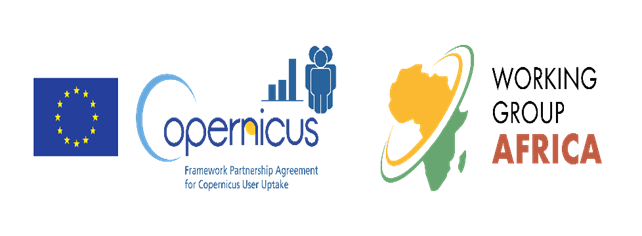

### **Day 4&5 - Deep Learning and foundation AI models for Earth Observation Data**

Carlos Gonzales-Inca
Department of Geogrtaphy and Geology, University of Turku, Finland
email: cagoin@utu.fi

# Introduction

Artificial Intelligence (AI) and Machine Learning methods have advanced rapidly and there are several applications and tools for Earth Observation data processing. Particularly, methods based on Convolutional neural networks, and deep learning are widely applied for object detection and semantic and instant segmentation. Then, with the development of new foundation AI models, more automated image processing methods are emerging, such as the Segment Anything Model (SAM, https://samgeo.gishub.org).

**Learning Objectives**
-         Introduction to the convolutional neural network, deep learning, and foundation AI models
-         Get familiar with Geospatial instant image segmentation
-         Exercise with foundation AI model for image segmentation in Python

# Part 1 - Object detection

In [ ]:
# Image segmentation using CNN, language -based SAM model
# ** This is high computing demand, thus change you CPU to GPU in Colab (Runtime > Change running type > T4 GPU > Save)

In [ ]:
# Segment Anything Model (SAM)
# Language SAM Model

In [ ]:
%pip install segment-geospatial groundingdino-py leafmap localtileserver

In [ ]:
import os
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

In [ ]:
my_map = leafmap.Map() # lat, lon e.g., Dar es Salam
my_map.add_basemap("SATELLITE")
my_map
# Once the map is visualized, navegate to your area of interest and drawn a polygon over the image, use the drawing tool of the viewer for it, e.g., using the solid square tool.

In [ ]:
# Get the AOI coordinates
bbox = my_map.user_roi_bounds()
bbox

In [ ]:
# Download high resolution image and mosaic it
my_image = "My_image.tif"
tms_to_geotiff(output=my_image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

In [ ]:
# Display the downloaded image on the map
my_map.layers[-1].visible = False
my_map.add_raster(my_image, layer_name="my_Image")
my_map

In [ ]:
# Initialize LangSAM Model
sam = LangSAM()

In [ ]:
# Specify text prompts
text_prompt = "forest"
#text_prompt ="building"

In [ ]:
# Segment the image
sam.predict(my_image, text_prompt, box_threshold=0.25, text_threshold=0.25)

These threshold values range from 0 to 1.

box_threshold: A higher value makes the model more selective, identifying only the most confident object instances. A lower value, conversely, makes the model more tolerant, including potentially less confident ones.

text_threshold: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt. A lower value allows for looser associations, and can introduce less precise matches.

In [ ]:
# Visualize the results
sam.show_anns(
    cmap='Greens',
    box_color='red',
    title='Tree detection',
    blend=True,
)

In [ ]:
# Show the result without bounding boxes on the map
sam.show_anns(
    cmap='Greens',
    add_boxes=False,
    alpha=0.5,
    title='Tree detection',
)

In [ ]:
sam.show_anns(
    cmap='Greys_r',
    add_boxes=False,
    alpha=1,
    title='Trees detection',
    blend=False,
    output='tree.tif',
)

In [ ]:
# Convert the result to a vector format, e.g., shapefile
sam.raster_to_vector("tree.tif", "tree.shp")

# **Part 2 - Automatic semantic image segmentation**

In [ ]:
# Import SamGeo model

from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [ ]:
# Initialize SAM all class
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

In [ ]:
# Automatic mask generation
sam.generate(my_image, output="masks.tif", foreground=True, unique=True)

In [ ]:
sam.show_masks(cmap="binary_r")

In [ ]:
# Show the object annotations (objects with random color) on the map
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

In [ ]:
# Compare images with a slider
leafmap.image_comparison(
    "My_image.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [ ]:
# Add image to the map
my_map.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
my_map

In [ ]:
# Export the vector as geopackage
sam.tiff_to_vector("masks.tif", "masks.gpkg")

# Automatic SamGeo parameters tunning for mask generation

**SanGeo model parameters:**

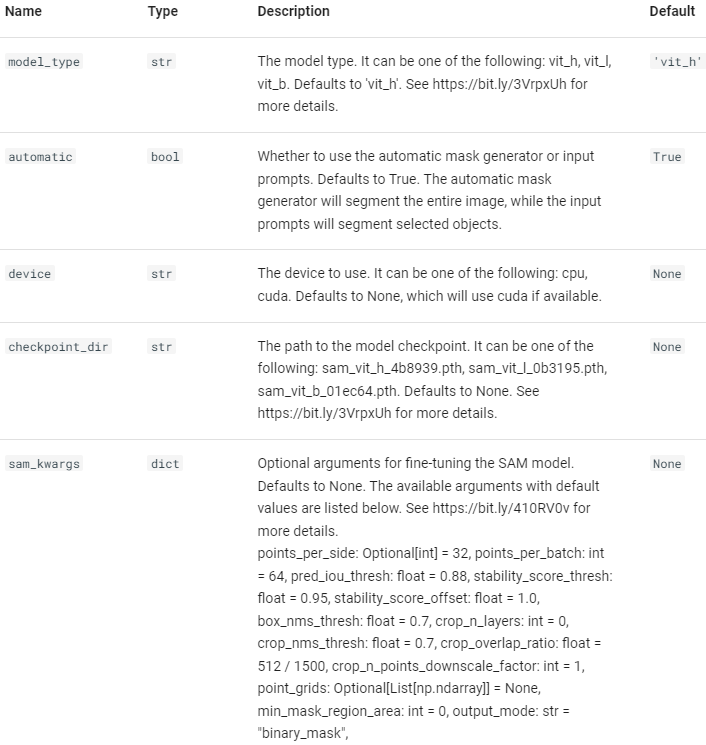

model (Sam): The SAM model to use for mask prediction.

          **points_per_side** (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.

          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          **pred_iou_thresh** (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.

          **stability_score_thresh** (float): A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.

          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.

          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.

          **crop_n_layers** (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.

          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.

          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.

          **crop_n_points_downscale_factor** (int): The number of points-per-side sampled in layer n is scaled down crop_n_points_downscale_factor**n.

          point_grids (list(np.ndarray) or None): A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.

          **min_mask_region_area** (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
            
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [ ]:
sam.generate(my_image, output="masks2.tif", foreground=True)

In [ ]:
sam.show_masks(cmap="binary_r")

In [ ]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

In [ ]:
# Compare images with a slider
leafmap.image_comparison(
    my_image,
    "annotations.tif",
    label1="Image",
    label2="Image Segmentation",
)